In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.utils import resample
from scipy.spatial.distance import pdist, squareform
from itertools import combinations

In [4]:
COPDGene_dataset = pd.read_csv('/home/shussein/NetCO/data/COPDGene/COPDGene_P1P2P3_dataset_92.csv', index_col=0)
COPDGene_clinical_dataset = pd.read_csv('/home/shussein/NetCO/data/COPDGene/COPDGene_P1P2P3_SM_NS_Long_Oct23.csv', index_col=0, low_memory=False)

In [5]:
COPDGene_dataset_df = COPDGene_dataset.reset_index()
COPDGene_dataset_sorted_df = COPDGene_dataset_df.sort_values(by=['SID', 'Visitnum'], kind='mergesort')
COPDGene_dataset = COPDGene_dataset_sorted_df.set_index('SID')

In [6]:
# 1. Combine 'SID' and 'Visitnum' into a MultiIndex for COPDGene_dataset
filter_criteria = pd.MultiIndex.from_tuples(
    [(index, row['Visitnum']) for index, row in COPDGene_dataset.iterrows()],
    names=['SID', 'Visitnum']
)
# 2. Create a MultiIndex for COPDGene_clinical_dataset
COPDGene_clinical_dataset_index = pd.MultiIndex.from_tuples(
    [(index, row['visitnum']) for index, row in COPDGene_clinical_dataset.iterrows()],
    names=['sid', 'visitnum']
)
COPDGene_clinical_dataset = COPDGene_clinical_dataset[COPDGene_clinical_dataset_index.isin(filter_criteria)]
COPDGene_clinical_dataset

,cohort,ccenter,Phase_study,visitnum,shortterm_flag,Visit_Year,phase_baseline,days_since_baseline,years_from_baseline,years_since_last_visit,...,SVI2018_RPL_THEME2,SVI2018_RPL_THEME3,SVI2018_RPL_THEME4,SVI2018_RPL_THEMES,ADI2018_ADI_SUPPRESSION_CODE,ADI2018_ADI_NATRANK,ADI2018_ADI_STATERNK,end_of_record,Unnamed: 1044,Unnamed: 1045
sid,,,,,,,,,,,,,,,,,,,,,
10062C,Smoker,NJC,1,1,0,2008,1,0,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
10062C,Smoker,NJC,2,2,0,2013,1,1969,5.390828,5.33,...,0.1067,0.5421,0.3380,0.1463,NaN,11.0,2.0,1.0,NaN,NaN
10062C,Smoker,NJC,3,3,0,2018,1,3701,10.130000,4.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
10077P,Smoker,NJC,1,1,0,2008,1,0,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
10077P,Smoker,NJC,2,2,0,2013,1,1988,5.442847,5.50,...,0.5500,0.2513,0.2076,0.1212,NaN,14.0,2.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21449L,Smoker,UIA,2,2,0,2015,1,1903,5.210130,5.17,...,0.3247,0.1044,0.4013,0.1619,NaN,67.0,6.0,1.0,NaN,NaN
21449L,Smoker,UIA,3,3,0,2019,1,3493,9.560000,4.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
22660M,Smoker,NJC,1,1,0,2010,1,0,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [7]:
# Adjusting for Age and Sex using Regression Residuals
import pandas as pd
import statsmodels.api as sm

COPDGene_dataset['age_visit'] = COPDGene_clinical_dataset['age_visit']
COPDGene_dataset['gender'] = COPDGene_clinical_dataset['gender']
# Adjust each Protein for Age
COPDGene_dataset_adjusted = COPDGene_dataset.copy()
protein_columns = [col for col in COPDGene_dataset_adjusted.columns if col.startswith('X')]

for protein in protein_columns:
    # Regression Model: Protein ~ Age
    X = sm.add_constant(COPDGene_dataset[['age_visit', 'gender']])  # Add intercept
    y = COPDGene_dataset[protein]
    model = sm.OLS(y, X).fit()

    # Residuals are the Age-Adjusted Values
    COPDGene_dataset_adjusted[protein] = model.resid

COPDGene_dataset = COPDGene_dataset_adjusted
COPDGene_dataset

,X10339_48,X11105_171,X11510_31,X13090_17,X14116_129,X2201_17,X2418_55,X2579_17,X2602_2,X2609_59,...,X5456_59,X5465_32,X5483_1,X5843_60,X6641_60,X7655_11,Visitnum,finalgold_visit,age_visit,gender
SID,,,,,,,,,,,,,,,,,,,,,
10062C,547.246897,35301.784802,13350.834640,1951.374172,421.186853,22275.557254,16378.504307,-15340.834535,-3293.574788,-209.629468,...,-545.646867,-76.489825,1800.302858,-155.348798,640.039240,-1884.858797,1,3.0,64.6,1
10062C,-3975.397085,-2321.313897,10391.916802,271.869899,690.906843,34779.868198,1958.947437,-602.917057,-4716.836588,-216.724194,...,-1649.495568,9.115048,1029.319740,-347.286785,974.555279,7354.341627,2,4.0,70.0,1
10062C,3584.530486,3039.087259,-8592.610165,-998.100567,47.335723,-35144.333186,-21292.692003,-13812.268187,12658.641811,89.913827,...,-1223.749968,-946.225065,-6451.498588,513.390559,-782.574907,4955.519783,3,4.0,74.8,1
10077P,215.593346,-4110.352873,18279.836134,798.048011,665.990042,19010.474956,-1034.071823,-15138.135240,-2974.529668,-240.506791,...,1815.875023,791.498353,1285.033499,-164.322045,992.061324,497.074463,1,3.0,62.4,2
10077P,-5203.250637,-9482.751572,5809.518296,-298.756262,37.610032,21665.785900,22406.071307,-447.717761,-4407.491469,-414.801517,...,196.826322,597.903225,881.050380,-217.660033,47.177364,3158.774887,2,3.0,67.8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21449L,-4117.586414,-8043.001500,3338.972861,-1157.623166,258.855587,26044.342063,-581.737408,-3309.983457,-4434.661569,-148.167891,...,-738.670828,289.325718,1205.667985,-399.417699,-573.199523,11964.486022,2,1.0,68.1,2
21449L,5615.455527,-1966.233773,-12386.093526,-1061.837759,-61.876273,-35722.667538,-29688.731894,-13434.013659,7927.510298,-89.574705,...,785.370972,-943.611052,-7037.240482,602.936534,-1097.760527,25469.549331,3,0.0,72.5,2
22660M,-3237.423066,32802.449584,10801.991329,1818.273273,551.238912,20501.184516,38187.031867,-962.168891,-5729.013069,-16.863496,...,471.071922,843.763112,3983.832053,-396.482688,683.447177,-4190.146958,1,0.0,72.6,2


In [8]:
# Using ComBat to Correct for Batch Effect
from combat.pycombat import pycombat
# Add Batch Information as a Categorical Column
COPDGene_dataset['Batch'] = COPDGene_dataset['Visitnum'].apply(lambda x: 'V3' if x in [1, 2] else 'V4')

# Apply ComBat to Correct for Batch Effect
protein_columns = [col for col in COPDGene_dataset.columns if col.startswith('X')]
protein_data_corrected = pycombat(COPDGene_dataset[protein_columns].T, batch=COPDGene_dataset['Batch']).T

# Update the DataFrame
COPDGene_dataset[protein_columns] = protein_data_corrected
COPDGene_dataset

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


,X10339_48,X11105_171,X11510_31,X13090_17,X14116_129,X2201_17,X2418_55,X2579_17,X2602_2,X2609_59,...,X5465_32,X5483_1,X5843_60,X6641_60,X7655_11,Visitnum,finalgold_visit,age_visit,gender,Batch
SID,,,,,,,,,,,,,,,,,,,,,
10062C,3092.930061,43591.008676,4925.050907,1503.192094,225.149646,2119.621842,2372.650274,-14740.524032,355.919009,-138.969861,...,-285.438154,-499.218167,121.838589,160.545661,-2235.616714,1,3.0,64.6,1,V3
10062C,-2595.328228,-684.570322,3111.525474,95.705494,434.160197,8584.753118,-6768.353492,-2824.655938,-995.511812,-146.152158,...,-235.173709,-954.627710,-140.609243,397.853000,5622.944611,2,4.0,70.0,1,V3
10062C,-173.266904,-289.901516,744.691990,-480.758004,183.136656,221.301294,1748.022489,-4837.822463,2755.581705,-43.481598,...,-50.152607,-452.210018,18.481077,32.408490,4195.284562,3,4.0,74.8,1,V4
10077P,2675.799933,-2789.945457,7946.043737,536.662182,414.851749,431.469189,-8665.721113,-14576.638051,658.862156,-170.228307,...,224.216764,-803.580971,109.568953,410.271875,-209.622285,1,3.0,62.4,2,V3
10077P,-4139.634649,-9112.286551,302.966165,-382.500300,-72.090477,1804.350422,6193.711708,-2699.174550,-701.779113,-346.674380,...,110.543892,-1042.208463,36.636859,-260.033495,2054.332934,2,3.0,67.8,2,V3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21449L,-2774.163801,-7417.961249,-1211.235048,-1102.262481,99.356420,4068.204907,-8378.972316,-5013.367212,-727.577958,-76.749654,...,-70.642958,-850.461132,-211.890834,-700.131937,9544.182464,2,1.0,68.1,2,V3
21449L,1360.576729,-3680.971545,-704.295540,-525.747392,118.478991,39.321112,-1960.073546,-4609.663604,334.262433,-185.278000,...,-49.158689,-673.469599,78.836097,-165.314567,17546.122413,3,0.0,72.5,2,V4
22660M,-1667.157262,40649.743399,3362.860802,1391.648626,325.929171,1202.214018,16197.751444,-3115.117428,-1956.604488,56.175451,...,254.904961,790.563682,-207.877626,191.339468,-4196.419332,1,0.0,72.6,2,V3


In [9]:
COPDGene_dataset_P1 = COPDGene_dataset.loc[COPDGene_dataset['Visitnum'] == 1]
COPDGene_dataset_P2 = COPDGene_dataset.loc[COPDGene_dataset['Visitnum'] == 2]
COPDGene_dataset_P3 = COPDGene_dataset.loc[COPDGene_dataset['Visitnum'] == 3]

In [33]:
from sklearn.preprocessing import StandardScaler


# Functions for metrics
def pairwise_distance_stress(X1, X2):
    """Compute stress between pairwise distances of two manifolds."""
    D1 = squareform(pdist(X1))
    D2 = squareform(pdist(X2))
    stress = np.sqrt(np.sum((D1 - D2)**2) / np.sum(D1**2))
    return stress

def neighborhood_preservation(X1, X2, k=5):
    """Compute neighborhood preservation between two manifolds."""
    from sklearn.neighbors import NearestNeighbors
    nbrs1 = NearestNeighbors(n_neighbors=k).fit(X1)
    nbrs2 = NearestNeighbors(n_neighbors=k).fit(X2)
    knn1 = nbrs1.kneighbors(X1, return_distance=False)
    knn2 = nbrs2.kneighbors(X2, return_distance=False)
    scores = [len(set(knn1[i]) & set(knn2[i])) / k for i in range(X1.shape[0])]
    return np.mean(scores)

# Stability function
def manifold_stability(data, n_subsamples=10, sample_size=0.8, n_neighbors=15, n_components=3, k=30):
    """
    Measure the stability of a manifold using subsampling and consistency metrics.
    :param data: Input high-dimensional data (n_samples, n_features)
    :param n_subsamples: Number of random subsamples
    :param sample_size: Fraction of data to subsample (0 < sample_size <= 1)
    :param n_neighbors: Number of neighbors for LLE
    :param n_components: Number of components for LLE
    :param k: Number of neighbors for neighborhood preservation
    :return: Dictionary with average and std of metrics
    """
    metrics = {
        "Pairwise Distance Stress": [],
        "Neighborhood Preservation": []
    }
    manifolds = []

    X = data.loc[:, data.columns.str.startswith('X')]
    Y = COPDGene_dataset['finalgold_visit']
    corr = X.corrwith(Y).abs().sort_values(ascending=False)
    trimmed = X[corr[:k].index.tolist()]


    # Standardize the dataset
    scaler = StandardScaler()
    trimmed = pd.DataFrame(scaler.fit_transform(trimmed), columns=trimmed.columns)

    # Generate subsampled manifolds
    for i in range(n_subsamples):
        subsample = resample(trimmed, n_samples=int(sample_size * len(data)), random_state=i)
        lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, random_state=42)
        embedding = lle.fit_transform(subsample)
        manifolds.append(embedding)

    # Compare all pairs of manifolds
    for idx1, idx2 in combinations(range(len(manifolds)), 2):
        X1, X2 = manifolds[idx1], manifolds[idx2]
        stress = pairwise_distance_stress(X1, X2)
        preservation = neighborhood_preservation(X1, X2, k=k)
        metrics["Pairwise Distance Stress"].append(stress)
        metrics["Neighborhood Preservation"].append(preservation)

    # Compute averages and standard deviations
    results = {key: (np.mean(val), np.std(val)) for key, val in metrics.items()}
    return results


np.random.seed(42)
# Measure stability
stability_results = manifold_stability(COPDGene_dataset_P3, n_subsamples=10, sample_size=0.8, n_neighbors=30, n_components=3, k=50)

# Print results
print("Manifold Stability Results:")
for metric, (mean, std) in stability_results.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")


Manifold Stability Results:
Pairwise Distance Stress: Mean = 0.5951, Std = 0.0231
Neighborhood Preservation: Mean = 0.6175, Std = 0.0160


In [38]:
COPDGene_dataset_P3

,X10339_48,X11105_171,X11510_31,X13090_17,X14116_129,X2201_17,X2418_55,X2579_17,X2602_2,X2609_59,...,X5465_32,X5483_1,X5843_60,X6641_60,X7655_11,Visitnum,finalgold_visit,age_visit,gender,Batch
SID,,,,,,,,,,,,,,,,,,,,,
10062C,-173.266904,-289.901516,744.691990,-480.758004,183.136656,221.301294,1748.022489,-4837.822463,2755.581705,-43.481598,...,-50.152607,-452.210018,18.481077,32.408490,4195.284562,3,4.0,74.8,1,V4
10077P,-2072.643069,-2189.583624,795.931764,356.982677,-16.760496,-292.743606,-1786.385458,544.650516,1013.014813,21.447964,...,-42.637162,-677.604017,347.185998,-27.313265,33.922859,3,3.0,72.3,2,V4
10104S,-1707.880014,184.259635,-1474.679230,-382.263347,-218.995882,-4857.252411,1936.830947,2262.783697,256.882680,441.869453,...,-96.040557,-346.686181,83.760855,-360.301815,-1344.983559,3,0.0,60.5,2,V4
10186U,-912.279130,-5875.000801,-5333.641795,-687.570165,-42.417880,-3035.436651,-7393.381238,-10002.898366,1385.096073,321.604496,...,-141.296110,-71.507453,467.042679,-343.190408,-223.831830,3,0.0,60.2,2,V4
10298F,-3738.631248,-7246.627373,928.384401,-259.705859,55.905597,964.366172,1173.444658,4015.010845,2278.528392,-499.842616,...,6.207668,-7.247104,-78.480355,93.934284,-1765.724818,3,1.0,79.8,2,V4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20975B,-3796.956455,-6468.889217,538.147652,-320.930848,-102.792626,-593.797681,-355.650060,-3104.849113,-658.512236,-333.588049,...,116.345525,-167.528005,461.646112,-158.930376,-1974.754929,3,0.0,72.2,2,V4
21270U,2775.570728,-1924.578034,2136.726592,-632.435272,417.479370,2550.009592,5056.461546,-4470.412477,1204.604190,624.567846,...,1.059453,1290.454775,-323.594890,276.167306,-2245.197033,3,2.0,82.2,1,V4
21272Y,3732.986241,-823.045964,-4561.210319,-446.852211,-201.764852,-3965.136101,-6583.539425,-2457.134901,3163.544835,228.284499,...,-175.158391,-879.249969,-190.344195,-572.727392,4963.510573,3,3.0,58.8,1,V4


(91, 3)
(91, 3)
Manifold 1 aligned to reference with similarity score: 1.0000
(91, 3)
(91, 3)
Manifold 2 aligned to reference with similarity score: 0.0343
(91, 3)
(92, 3)
Manifold 3 aligned to reference with similarity score: 0.0310
(91, 3)
(92, 3)
Manifold 4 aligned to reference with similarity score: 0.0182
(91, 3)
(92, 3)
Manifold 5 aligned to reference with similarity score: 0.0320
(91, 3)
(92, 3)
Manifold 6 aligned to reference with similarity score: 0.1293
(91, 3)
(92, 3)
Manifold 7 aligned to reference with similarity score: 0.0162
(91, 3)
(92, 3)
Manifold 8 aligned to reference with similarity score: 0.0413
(91, 3)
(92, 3)
Manifold 9 aligned to reference with similarity score: 0.0102
(91, 3)
(92, 3)
Manifold 10 aligned to reference with similarity score: 0.0553


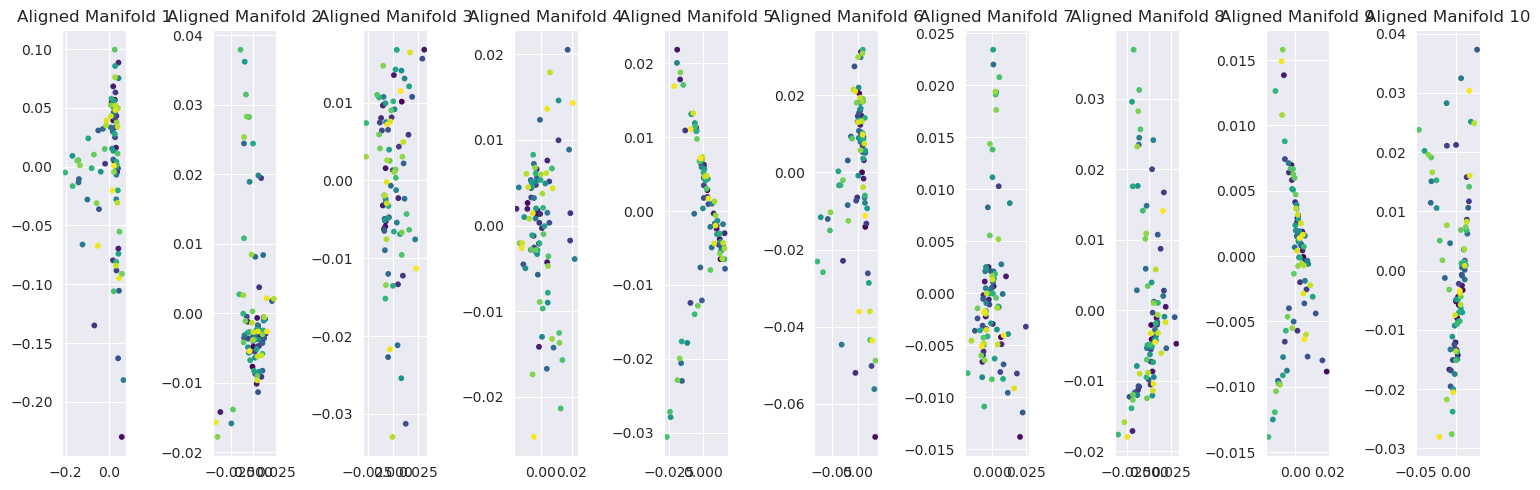

Average Procrustes Similarity Score: 0.1368
Split 1:
  Reconstruction Error: 0.0050
  Distance Preservation: 0.7014
  Neighborhood Preservation: 0.4923
Split 2:
  Reconstruction Error: 0.0071
  Distance Preservation: 0.7140
  Neighborhood Preservation: 0.4516
Split 3:
  Reconstruction Error: 0.0070
  Distance Preservation: 0.6514
  Neighborhood Preservation: 0.3946
Split 4:
  Reconstruction Error: 0.0045
  Distance Preservation: 0.7372
  Neighborhood Preservation: 0.5130
Split 5:
  Reconstruction Error: 0.0068
  Distance Preservation: 0.7300
  Neighborhood Preservation: 0.4663
Split 6:
  Reconstruction Error: 0.0055
  Distance Preservation: 0.7277
  Neighborhood Preservation: 0.4641
Split 7:
  Reconstruction Error: 0.0089
  Distance Preservation: 0.7091
  Neighborhood Preservation: 0.4978
Split 8:
  Reconstruction Error: 0.0049
  Distance Preservation: 0.6708
  Neighborhood Preservation: 0.4772
Split 9:
  Reconstruction Error: 0.0060
  Distance Preservation: 0.6082
  Neighborhood Prese

In [48]:
from sklearn.model_selection import KFold
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate pairwise distance preservation
def calculate_distance_preservation(original_data, manifold_data):
    original_distances = pairwise_distances(original_data)
    manifold_distances = pairwise_distances(manifold_data)
    correlation = np.corrcoef(original_distances.flatten(), manifold_distances.flatten())[0, 1]
    return correlation

# Function to calculate neighborhood preservation
def calculate_neighborhood_preservation(original_data, manifold_data, n_neighbors=10):
    original_neighbors = np.argsort(pairwise_distances(original_data), axis=1)[:, 1:n_neighbors+1]
    manifold_neighbors = np.argsort(pairwise_distances(manifold_data), axis=1)[:, 1:n_neighbors+1]
    intersection_count = 0
    for i in range(original_neighbors.shape[0]):
        intersection_count += len(set(original_neighbors[i]).intersection(set(manifold_neighbors[i])))
    return intersection_count / (original_neighbors.shape[0] * n_neighbors)

# Cross-validation for manifold learning
def manifold_cross_validation(data, n_splits=3, n_components=3, n_neighbors=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    manifolds = []
    metrics = []

    # print(data)
    for train_index, test_index in kf.split(data):
        # print(train_index, test_index)
        train_data = data.iloc[train_index]

        # Apply LLE
        lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors)
        manifold = lle.fit_transform(train_data)
        manifolds.append(manifold)

        # Quantitative metrics
        reconstruction_error = lle.reconstruction_error_
        distance_preservation = calculate_distance_preservation(train_data, manifold)
        neighborhood_preservation = calculate_neighborhood_preservation(train_data, manifold, n_neighbors)
        metrics.append({
            "Reconstruction Error": reconstruction_error,
            "Distance Preservation": distance_preservation,
            "Neighborhood Preservation": neighborhood_preservation
        })

    return manifolds, metrics

COPDGene_dataset_P3_V = COPDGene_dataset_P3.loc[:, COPDGene_dataset_P3.columns.str.startswith('X')]
# Run cross-validation
manifolds, metrics = manifold_cross_validation(COPDGene_dataset_P3_V, n_splits=10, n_components=3, n_neighbors=10)

from scipy.spatial import procrustes
import matplotlib.pyplot as plt
import numpy as np

# Function to perform Procrustes Analysis
def align_manifolds(reference, manifold):
    """
    Aligns a manifold to the reference manifold using Procrustes Analysis.
    Returns the aligned manifold and the Procrustes similarity score.
    """
    mtx1, mtx2, disparity = procrustes(reference, manifold)
    return mtx2, 1 - disparity  # Return aligned manifold and similarity score

# Align all manifolds to the first one (as reference)
reference_manifold = manifolds[0]
aligned_manifolds = []
similarity_scores = []


for i, manifold in enumerate(manifolds):
    print(reference_manifold.shape)
    print(manifold.shape)
    min_length = min(reference_manifold.shape[0], manifold.shape[0])
    reference_manifold = reference_manifold[:min_length]
    manifold = manifold[:min_length]

    aligned, similarity = align_manifolds(reference_manifold, manifold)
    aligned_manifolds.append(aligned)
    similarity_scores.append(similarity)
    print(f"Manifold {i+1} aligned to reference with similarity score: {similarity:.4f}")

# Visualize the aligned manifolds
fig, axes = plt.subplots(1, len(aligned_manifolds), figsize=(15, 5))
for i, aligned_manifold in enumerate(aligned_manifolds):
    axes[i].scatter(aligned_manifold[:, 0], aligned_manifold[:, 1], c=np.arange(aligned_manifold.shape[0]), cmap='viridis', s=10)
    axes[i].set_title(f"Aligned Manifold {i+1}")
plt.tight_layout()
plt.show()

# Average similarity score
average_similarity = np.mean(similarity_scores)
print(f"Average Procrustes Similarity Score: {average_similarity:.4f}")

# Print metrics
for i, metric in enumerate(metrics):
    print(f"Split {i+1}:")
    print(f"  Reconstruction Error: {metric['Reconstruction Error']:.4f}")
    print(f"  Distance Preservation: {metric['Distance Preservation']:.4f}")
    print(f"  Neighborhood Preservation: {metric['Neighborhood Preservation']:.4f}")

# # Qualitative comparison - visualize manifolds
# fig, axes = plt.subplots(1, len(manifolds), figsize=(15, 5))
# for i, manifold in enumerate(manifolds):
#     axes[i].scatter(manifold[:, 0], manifold[:, 1], c=np.arange(manifold.shape[0]), cmap='viridis', s=10)
#     axes[i].set_title(f"Manifold Split {i+1}")
# plt.tight_layout()
# plt.show()


In [49]:
SPIROMICS_dataset = pd.read_csv('/home/shussein/NetCO/data/SPIROMICS/SPIROMICS_V1V2V4V5_100.csv', index_col=0)
# Standardization Code
SPIROMICS_dataset_columns = SPIROMICS_dataset.loc[:, ~SPIROMICS_dataset.columns.isin(['VISIT', 'GOLD_STAGE_COPD_SEVERITY'])].columns
scaler = StandardScaler()
SPIROMICS_dataset[SPIROMICS_dataset_columns] = scaler.fit_transform(SPIROMICS_dataset[SPIROMICS_dataset_columns])
SPIROMICS_dataset.VISIT = SPIROMICS_dataset.VISIT.replace({'BASELINE': 1, 'YEAR1': 2, 'YEAR3': 4, 'VISIT5': 5})
SPIROMICS_dataset_P1 = SPIROMICS_dataset.loc[SPIROMICS_dataset['VISIT'] == 1]
SPIROMICS_dataset_P2 = SPIROMICS_dataset.loc[SPIROMICS_dataset['VISIT'] == 2]
SPIROMICS_dataset_P4 = SPIROMICS_dataset.loc[SPIROMICS_dataset['VISIT'] == 4]
SPIROMICS_dataset_P5 = SPIROMICS_dataset.loc[SPIROMICS_dataset['VISIT'] == 5]

/tmp/ipykernel_2557883/35192660.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  SPIROMICS_dataset.VISIT = SPIROMICS_dataset.VISIT.replace({'BASELINE': 1, 'YEAR1': 2, 'YEAR3': 4, 'VISIT5': 5})


In [50]:
SPIROMICS_dataset_P2

,X10620_21,X11109_56,X11178_21,X11214_40,X11278_4,X11388_75,X12549_33,X13397_88,X13565_2,X13660_76,...,X6605_17,X7893_19,X8245_27,X8464_31,X8841_65,X8885_6,X9756_6,X9793_145,VISIT,GOLD_STAGE_COPD_SEVERITY
SUBJID,,,,,,,,,,,,,,,,,,,,,
CU100010,0.227650,-0.160828,-0.243055,-0.451856,0.702192,-0.068171,-0.285937,-0.527255,-1.086281,-0.430353,...,0.648534,-0.154658,0.753948,0.273740,0.118752,0.076845,-0.827559,1.219699,2,0
CU100023,0.848464,-0.900030,-0.895345,0.899606,0.486033,-0.079221,-0.512059,-0.483345,-0.648777,-0.441799,...,0.896548,-0.848754,1.109435,-0.517563,0.030956,-0.450423,-0.705954,0.351924,2,0
CU100047,-0.235838,0.246137,0.509943,1.566704,1.783043,1.003099,2.098232,-0.659485,0.784116,-0.394325,...,0.101160,1.016945,1.217292,-0.047910,0.270771,1.548307,-0.766682,0.521388,2,0
CU100079,0.278815,0.228530,0.330603,1.025601,0.637451,0.733602,1.168619,-0.674423,2.067190,-0.255553,...,-0.915959,-0.986012,0.052469,0.413683,0.946317,1.165551,0.853038,1.014588,2,0
CU100103,-0.395397,-0.918581,-0.755682,0.960445,1.214815,0.237470,2.561643,0.309310,0.011415,-0.104073,...,-0.382192,-0.295693,1.723456,-0.032524,0.308436,-0.239943,-0.324887,-0.078750,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WF124147,-0.153777,-0.230839,-0.386758,1.766030,0.270550,0.089595,-0.448200,1.158788,-0.277438,0.306137,...,-1.580250,0.273738,-1.115182,-0.005414,1.824284,-0.356455,0.179706,-0.810953,2,1
WF124740,0.942563,2.459238,2.597098,-0.091732,2.138101,0.174034,0.669964,0.375413,0.228272,1.404236,...,-1.448769,0.718252,1.521678,0.596123,2.505521,1.967368,0.101246,0.420878,2,3
WF124967,1.517268,0.988798,0.812065,-0.357320,-0.483440,1.549234,1.161989,-0.232232,0.234976,-0.207155,...,0.602525,-0.437232,2.924233,0.157975,-0.493656,0.212577,-0.041635,-0.058881,2,2


(722, 3)
(722, 3)
Manifold 1 aligned to reference with similarity score: 1.0000
(722, 3)
(722, 3)
Manifold 2 aligned to reference with similarity score: 0.0109
(722, 3)
(722, 3)
Manifold 3 aligned to reference with similarity score: 0.0033
(722, 3)
(723, 3)
Manifold 4 aligned to reference with similarity score: 0.0057
(722, 3)
(723, 3)
Manifold 5 aligned to reference with similarity score: 0.0088
(722, 3)
(723, 3)
Manifold 6 aligned to reference with similarity score: 0.0136
(722, 3)
(723, 3)
Manifold 7 aligned to reference with similarity score: 0.0020
(722, 3)
(723, 3)
Manifold 8 aligned to reference with similarity score: 0.0021
(722, 3)
(723, 3)
Manifold 9 aligned to reference with similarity score: 0.0107
(722, 3)
(723, 3)
Manifold 10 aligned to reference with similarity score: 0.0068


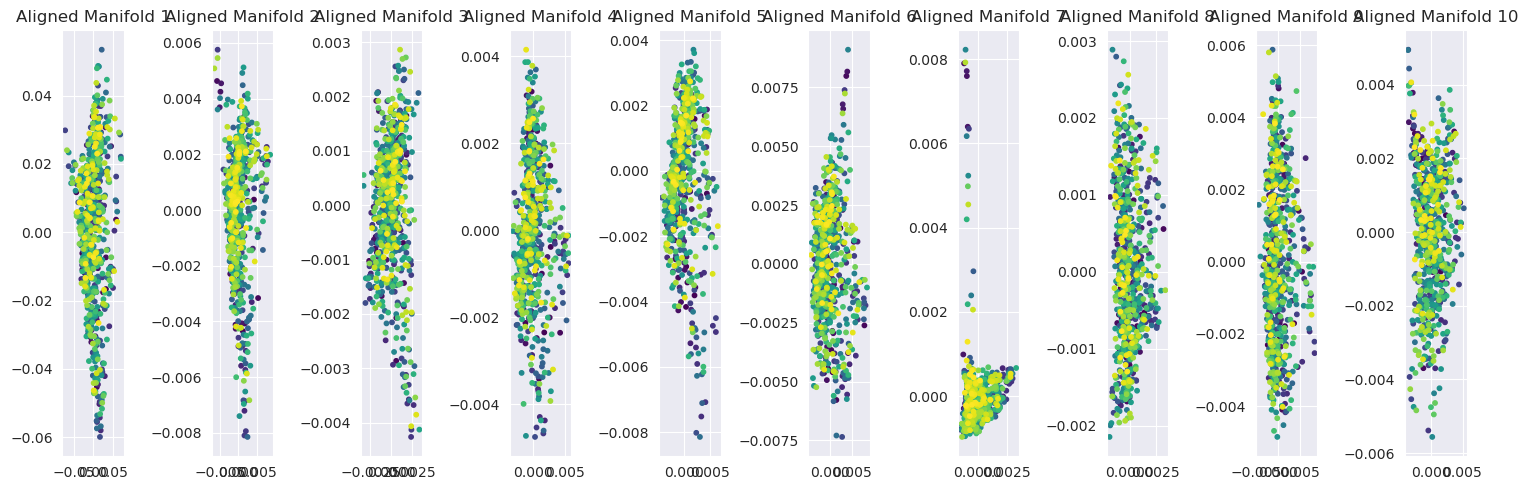

Average Procrustes Similarity Score: 0.1064
Split 1:
  Reconstruction Error: 0.0332
  Distance Preservation: -0.0511
  Neighborhood Preservation: 0.0896
Split 2:
  Reconstruction Error: 0.0245
  Distance Preservation: 0.2390
  Neighborhood Preservation: 0.0903
Split 3:
  Reconstruction Error: 0.0346
  Distance Preservation: 0.0894
  Neighborhood Preservation: 0.0900
Split 4:
  Reconstruction Error: 0.0255
  Distance Preservation: 0.0281
  Neighborhood Preservation: 0.0871
Split 5:
  Reconstruction Error: 0.0325
  Distance Preservation: -0.0237
  Neighborhood Preservation: 0.0878
Split 6:
  Reconstruction Error: 0.0297
  Distance Preservation: 0.2353
  Neighborhood Preservation: 0.0827
Split 7:
  Reconstruction Error: 0.0231
  Distance Preservation: 0.2401
  Neighborhood Preservation: 0.0795
Split 8:
  Reconstruction Error: 0.0307
  Distance Preservation: -0.0114
  Neighborhood Preservation: 0.0924
Split 9:
  Reconstruction Error: 0.0331
  Distance Preservation: 0.2474
  Neighborhood Pr

In [57]:
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import KFold
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate pairwise distance preservation
def calculate_distance_preservation(original_data, manifold_data):
    original_distances = pairwise_distances(original_data)
    manifold_distances = pairwise_distances(manifold_data)
    correlation = np.corrcoef(original_distances.flatten(), manifold_distances.flatten())[0, 1]
    return correlation

# Function to calculate neighborhood preservation
def calculate_neighborhood_preservation(original_data, manifold_data, n_neighbors=10):
    original_neighbors = np.argsort(pairwise_distances(original_data), axis=1)[:, 1:n_neighbors+1]
    manifold_neighbors = np.argsort(pairwise_distances(manifold_data), axis=1)[:, 1:n_neighbors+1]
    intersection_count = 0
    for i in range(original_neighbors.shape[0]):
        intersection_count += len(set(original_neighbors[i]).intersection(set(manifold_neighbors[i])))
    return intersection_count / (original_neighbors.shape[0] * n_neighbors)

# Cross-validation for manifold learning
def manifold_cross_validation(data, n_splits=3, n_components=3, n_neighbors=10):
    knn_graph = kneighbors_graph(data, n_neighbors=10, mode='distance')
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    manifolds = []
    metrics = []

    # print(data)
    for train_index, test_index in kf.split(data):
        # print(train_index, test_index)
        train_data = data.iloc[train_index]
        train_graph = knn_graph[train_index][:, train_index]

        # Apply LLE
        lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors,  eigen_solver='dense')
        manifold = lle.fit_transform(train_graph.toarray())
        manifolds.append(manifold)

        # Quantitative metrics
        reconstruction_error = lle.reconstruction_error_
        distance_preservation = calculate_distance_preservation(train_data, manifold)
        neighborhood_preservation = calculate_neighborhood_preservation(train_data, manifold, n_neighbors)
        metrics.append({
            "Reconstruction Error": reconstruction_error,
            "Distance Preservation": distance_preservation,
            "Neighborhood Preservation": neighborhood_preservation
        })

    return manifolds, metrics

SPIROMICS_dataset_P2_F = SPIROMICS_dataset_P2.loc[:, SPIROMICS_dataset_P2.columns.str.startswith('X')]

# Run cross-validation
manifolds, metrics = manifold_cross_validation(SPIROMICS_dataset_P2_F, n_splits=10, n_components=3, n_neighbors=10)

from scipy.spatial import procrustes
import matplotlib.pyplot as plt
import numpy as np

# Function to perform Procrustes Analysis
def align_manifolds(reference, manifold):
    """
    Aligns a manifold to the reference manifold using Procrustes Analysis.
    Returns the aligned manifold and the Procrustes similarity score.
    """
    mtx1, mtx2, disparity = procrustes(reference, manifold)
    return mtx2, 1 - disparity  # Return aligned manifold and similarity score

# Align all manifolds to the first one (as reference)
reference_manifold = manifolds[0]
aligned_manifolds = []
similarity_scores = []


for i, manifold in enumerate(manifolds):
    print(reference_manifold.shape)
    print(manifold.shape)
    min_length = min(reference_manifold.shape[0], manifold.shape[0])
    reference_manifold = reference_manifold[:min_length]
    manifold = manifold[:min_length]

    aligned, similarity = align_manifolds(reference_manifold, manifold)
    aligned_manifolds.append(aligned)
    similarity_scores.append(similarity)
    print(f"Manifold {i+1} aligned to reference with similarity score: {similarity:.4f}")

# Visualize the aligned manifolds
fig, axes = plt.subplots(1, len(aligned_manifolds), figsize=(15, 5))
for i, aligned_manifold in enumerate(aligned_manifolds):
    axes[i].scatter(aligned_manifold[:, 0], aligned_manifold[:, 1], c=np.arange(aligned_manifold.shape[0]), cmap='viridis', s=10)
    axes[i].set_title(f"Aligned Manifold {i+1}")
plt.tight_layout()
plt.show()

# Average similarity score
average_similarity = np.mean(similarity_scores)
print(f"Average Procrustes Similarity Score: {average_similarity:.4f}")

# Print metrics
for i, metric in enumerate(metrics):
    print(f"Split {i+1}:")
    print(f"  Reconstruction Error: {metric['Reconstruction Error']:.4f}")
    print(f"  Distance Preservation: {metric['Distance Preservation']:.4f}")
    print(f"  Neighborhood Preservation: {metric['Neighborhood Preservation']:.4f}")

# # Qualitative comparison - visualize manifolds
# fig, axes = plt.subplots(1, len(manifolds), figsize=(15, 5))
# for i, manifold in enumerate(manifolds):
#     axes[i].scatter(manifold[:, 0], manifold[:, 1], c=np.arange(manifold.shape[0]), cmap='viridis', s=10)
#     axes[i].set_title(f"Manifold Split {i+1}")
# plt.tight_layout()
# plt.show()


In [58]:
from sklearn.metrics import pairwise_distances
import numpy as np

# Compute pairwise distance matrices for all manifolds
distance_matrices = [pairwise_distances(manifold) for manifold in manifolds]

# Compute similarity between distance matrices (e.g., Pearson correlation)
def compare_distance_matrices(dm1, dm2):
    dm1_flat = dm1.flatten()
    dm2_flat = dm2.flatten()
    correlation = np.corrcoef(dm1_flat, dm2_flat)[0, 1]
    return correlation

# Compare all manifolds to the first one
reference_matrix = distance_matrices[0]
similarities = [compare_distance_matrices(reference_matrix, dm) for dm in distance_matrices]

# Print similarity scores
for i, similarity in enumerate(similarities):
    print(f"Similarity of Manifold {i+1} to Reference: {similarity:.4f}")


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 521284 and the array at index 1 has size 522729

In [59]:
def explained_variance(manifold):
    _, s, _ = np.linalg.svd(manifold, full_matrices=False)
    variance = np.cumsum(s**2) / np.sum(s**2)
    return variance

# Compute explained variance for each manifold
explained_variances = [explained_variance(manifold) for manifold in manifolds]

# Print the variance explained by the first few dimensions
for i, variance in enumerate(explained_variances):
    print(f"Explained Variance for Manifold {i+1}: {variance[:3]}")  # First 3 components


Explained Variance for Manifold 1: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 2: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 3: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 4: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 5: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 6: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 7: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 8: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 9: [0.33333333 0.66666667 1.        ]
Explained Variance for Manifold 10: [0.33333333 0.66666667 1.        ]


In [60]:
from scipy.linalg import subspace_angles

def compute_principal_angle_similarity(manifold1, manifold2):
    # Perform SVD to get the principal components of each manifold
    U1, _, _ = np.linalg.svd(manifold1, full_matrices=False)
    U2, _, _ = np.linalg.svd(manifold2, full_matrices=False)

    # Compute the principal angles
    angles = subspace_angles(U1, U2)
    similarity = np.cos(angles).mean()  # Cosine similarity of angles
    return similarity

# Compare all manifolds to the first one
reference_manifold = manifolds[0]
principal_angle_similarities = [compute_principal_angle_similarity(reference_manifold, manifold) for manifold in manifolds]

# Print similarity scores
for i, similarity in enumerate(principal_angle_similarities):
    print(f"Principal Angle Similarity of Manifold {i+1} to Reference: {similarity:.4f}")


ValueError: A and B must have the same number of rows, got 722 and 723

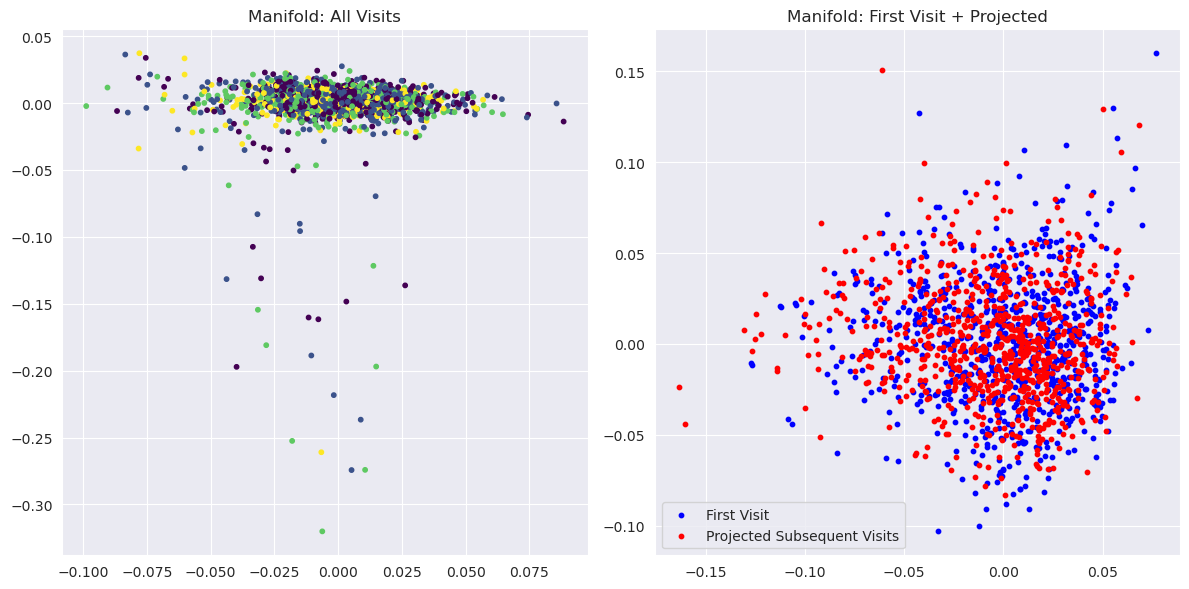

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 640000 and the array at index 1 has size 644809

In [68]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to generate a manifold
def generate_manifold(data, n_components=2, n_neighbors=50):
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    manifold = lle.fit_transform(data)
    return manifold, lle

# Generate a Manifold using All Visits
manifold_all, lle_all = generate_manifold(SPIROMICS_dataset.loc[:, SPIROMICS_dataset.columns.str.startswith('X')])

# Generate a Manifold using only the First Visit
manifold_first, lle_first = generate_manifold(SPIROMICS_dataset_P1.loc[:, SPIROMICS_dataset_P1.columns.str.startswith('X')])

# Project subsequent visits onto the first visit manifold
# SPIROMICS_dataset_subsequent_visits = SPIROMICS_dataset[SPIROMICS_dataset['VISIT'].isin([2, 4, 5])]
SPIROMICS_dataset_subsequent_visits = SPIROMICS_dataset[SPIROMICS_dataset['VISIT'].isin([2])]
projected_subsequent_visits = lle_first.transform(SPIROMICS_dataset_subsequent_visits.loc[:, SPIROMICS_dataset_subsequent_visits.columns.str.startswith('X')])

# Visualize the two manifolds side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot manifold generated from all visits
axes[0].scatter(manifold_all[:, 0], manifold_all[:, 1], c=SPIROMICS_dataset["VISIT"], cmap="viridis", s=10)
axes[0].set_title("Manifold: All Visits")

# Plot manifold from first visit with projected subsequent visits
axes[1].scatter(manifold_first[:, 0], manifold_first[:, 1], c="blue", label="First Visit", s=10)
axes[1].scatter(projected_subsequent_visits[:, 0], projected_subsequent_visits[:, 1], c="red", label="Projected Subsequent Visits", s=10)
axes[1].set_title("Manifold: First Visit + Projected")
axes[1].legend()

plt.tight_layout()
plt.show()

# Quantitative comparison: Pairwise distance preservation
def compare_distance_matrices(dm1, dm2):
    dm1_flat = dm1.flatten()
    dm2_flat = dm2.flatten()
    correlation = np.corrcoef(dm1_flat, dm2_flat)[0, 1]
    return correlation

# Compute pairwise distance matrices
dm_all = pairwise_distances(manifold_all)
dm_first = pairwise_distances(manifold_first)
dm_projected = pairwise_distances(projected_subsequent_visits)

# Compare distances
all_vs_first = compare_distance_matrices(dm_all[:len(dm_first), :len(dm_first)], dm_first)
first_vs_projected = compare_distance_matrices(dm_first, dm_projected)

print(f"Distance Correlation (All Visits vs First Visit): {all_vs_first:.4f}")
print(f"Distance Correlation (First Visit vs Projected Subsequent Visits): {first_vs_projected:.4f}")


In [66]:
SPIROMICS_dataset

,X10620_21,X11109_56,X11178_21,X11214_40,X11278_4,X11388_75,X12549_33,X13397_88,X13565_2,X13660_76,...,X6605_17,X7893_19,X8245_27,X8464_31,X8841_65,X8885_6,X9756_6,X9793_145,VISIT,GOLD_STAGE_COPD_SEVERITY
SUBJID,,,,,,,,,,,,,,,,,,,,,
CU100010,0.590480,0.602166,0.406927,0.667069,-0.112761,0.057175,-0.150194,-0.548938,-0.363423,-0.410412,...,0.186661,-0.180094,0.713350,0.444456,0.414389,0.117659,-0.394481,1.243073,5,0
CU100010,0.227650,-0.160828,-0.243055,-0.451856,0.702192,-0.068171,-0.285937,-0.527255,-1.086281,-0.430353,...,0.648534,-0.154658,0.753948,0.273740,0.118752,0.076845,-0.827559,1.219699,2,0
CU100010,0.480462,-0.103079,0.101775,-0.007988,0.404599,0.180323,-0.327928,-0.264660,-0.982808,-0.600218,...,0.468051,0.540950,1.765872,0.545567,0.195439,0.157999,-0.635474,1.543435,4,0
CU100023,0.187114,-0.853915,-0.767369,-0.084016,-0.826147,-0.861151,-0.425053,0.654034,-0.559294,-0.570657,...,0.353331,-0.852784,0.545504,-0.393739,-0.852701,-0.688667,-0.587009,-0.320675,5,0
CU100023,0.848464,-0.900030,-0.895345,0.899606,0.486033,-0.079221,-0.512059,-0.483345,-0.648777,-0.441799,...,0.896548,-0.848754,1.109435,-0.517563,0.030956,-0.450423,-0.705954,0.351924,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WF125183,0.422644,0.261858,0.640949,0.369133,-0.849382,0.753628,-0.473325,-0.302301,2.293666,1.260214,...,-0.923242,1.161758,1.411800,0.907515,-0.640255,-0.896774,-0.450038,-0.256980,5,3
WF125183,0.762971,0.386264,0.264090,0.871521,-0.652228,1.577381,0.893876,0.017191,1.581300,0.836237,...,-0.211483,1.475311,1.417657,1.119995,0.009548,-0.324895,-0.480771,0.478146,2,3
WF125209,0.381284,-0.406705,-0.483714,0.162550,-0.359993,0.937648,1.095572,1.512960,0.338158,1.257014,...,-2.387904,1.269046,1.261324,0.191679,-0.239480,0.783270,-0.329024,-0.757776,1,3


['JH113081', 'UI250372', 'JH112601', 'LA191759', 'MU164580', 'JH110267', 'UT170653', 'CU104149', 'WF122072', 'CU100195', 'MU160965', 'SF180735', 'MU160181', 'SF180283', 'SF181135', 'CU100178', 'MU161130', 'MU162879', 'NJ220477', 'WF120603', 'NJ220481', 'IA210123', 'CU100139', 'MU161107', 'SF180838', 'MU161191', 'CU102006', 'LA190736', 'MU162245', 'LA191567', 'WF121299', 'UT172656', 'MU160789', 'LA190213', 'UT171515', 'LA190769', 'SF180702', 'SF180926', 'LA191364', 'MU160809', 'MU161174', 'LA190722', 'CU103820', 'UT170233', 'MU162059', 'JH114236', 'MU160459', 'LA190608', 'LA190453', 'CU100419', 'UT173238', 'WF120433', 'MU161799', 'WF122515', 'SF182175', 'WF121810', 'WF121625', 'MU161365', 'JH110280', 'MU164331', 'UT171105', 'JH111569', 'MU160976', 'UT172073', 'UT172140', 'SF182863', 'WF123043', 'MU161189', 'UT170416', 'WF121348', 'MU163056', 'MU161027', 'WF123064', 'SF180421', 'CU100582', 'LA191462', 'SF180041', 'JH110070', 'CU102246', 'SF180201', 'SF180918', 'JH110130', 'UT173823', 'LA

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

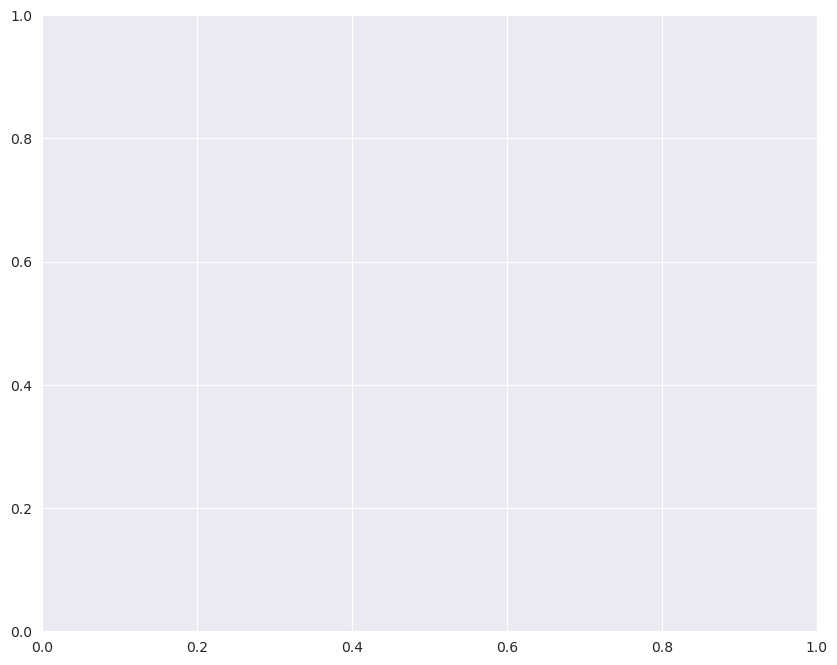

In [72]:
import random

# Randomly select 100 subjects
random_subjects = random.sample(list(SPIROMICS_dataset.index.unique()), 100)
print(random_subjects)

# Filter datasets for selected subjects
selected_first_visit_data = SPIROMICS_dataset_P1[SPIROMICS_dataset_P1.index.isin(random_subjects)]
selected_subsequent_visit_data = SPIROMICS_dataset_subsequent_visits[SPIROMICS_dataset_subsequent_visits.index.isin(random_subjects)]

# Map colors to the selected subjects
selected_subject_ids = selected_first_visit_data.index.unique()
subject_color_map = {subject: i for i, subject in enumerate(selected_subject_ids)}

# Assign colors to the selected first visit and subsequent visits
first_visit_colors = selected_first_visit_data.index.map(subject_color_map)
subsequent_visit_colors = selected_subsequent_visit_data.index.map(subject_color_map)

# Visualize the manifold with points colored by subject ID (for 100 random subjects)
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first visit manifold
scatter1 = ax.scatter(
    manifold_first[selected_first_visit_data.index, 0], manifold_first[selected_first_visit_data.index, 1],
    c=first_visit_colors,
    cmap="tab20",  # Use a larger qualitative color map for more subjects
    s=50,
    label="First Visit"
)

# Plot the projected subsequent visits
scatter2 = ax.scatter(
    projected_subsequent_visits[selected_subsequent_visit_data.index, 0], projected_subsequent_visits[selected_subsequent_visit_data.index, 1],
    c=subsequent_visit_colors,
    cmap="tab20",
    s=50,
    marker="x",
    label="Subsequent Visits"
)

# Add legend
legend1 = ax.legend(
    *scatter1.legend_elements(num=len(selected_subject_ids)),
    loc="upper right",
    title="Subjects"
)
ax.add_artist(legend1)

ax.set_title("Manifold: First Visit + Projected Subsequent Visits (Random 100 Subjects)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
plt.show()


In [64]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np


# Prepare data for LLE
features = SPIROMICS_dataset.loc[:, SPIROMICS_dataset.columns.str.startswith('X')]
metadata = SPIROMICS_dataset[["VISIT", "GOLD_STAGE_COPD_SEVERITY"]]

# Define LLE
n_neighbors = 50  # Number of neighbors for LLE
lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=3)

# Fit LLE to the data
lle.fit(features)

# Compute the k-nearest neighbors graph
neighbors_model = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean")
neighbors_model.fit(features)
distances, indices = neighbors_model.kneighbors(features)

# Analyze the neighbors for each point
neighbor_analysis = []

for i, subject_idx in enumerate(features.index):
    subject_metadata = metadata.iloc[i]
    sid = subject_idx
    visitnum = subject_metadata["VISIT"]
    phenotype = subject_metadata["GOLD_STAGE_COPD_SEVERITY"]

    # Neighbors
    neighbors = indices[i]

    # Count within-subject neighbors
    within_subject_count = sum(metadata.iloc[neighbor]["VISIT"] != visitnum for neighbor in neighbors if metadata.index[neighbor] == sid)

    # Count phenotype-based neighbors
    phenotype_count = sum(metadata.iloc[neighbor]["GOLD_STAGE_COPD_SEVERITY"] == phenotype and metadata.index[neighbor] != sid for neighbor in neighbors)

    # Save the analysis
    neighbor_analysis.append({
        "SID": sid,
        "Visitnum": visitnum,
        "Within_Subject_Neighbors": within_subject_count,
        "Phenotype_Based_Neighbors": phenotype_count,
        "Total_Neighbors": len(neighbors)
    })

# Convert to a DataFrame
neighbor_analysis_df = pd.DataFrame(neighbor_analysis)

# Compute proportions
neighbor_analysis_df["Within_Subject_Proportion"] = neighbor_analysis_df["Within_Subject_Neighbors"] / neighbor_analysis_df["Total_Neighbors"]
neighbor_analysis_df["Phenotype_Based_Proportion"] = neighbor_analysis_df["Phenotype_Based_Neighbors"] / neighbor_analysis_df["Total_Neighbors"]

# Display the results
print(neighbor_analysis_df)

# Aggregate results
mean_within_subject_proportion = neighbor_analysis_df["Within_Subject_Proportion"].mean()
mean_phenotype_based_proportion = neighbor_analysis_df["Phenotype_Based_Proportion"].mean()

print(f"Mean Within-Subject Neighbor Proportion: {mean_within_subject_proportion:.4f}")
print(f"Mean Phenotype-Based Neighbor Proportion: {mean_phenotype_based_proportion:.4f}")


           SID  Visitnum  Within_Subject_Neighbors  Phenotype_Based_Neighbors  \
0     CU100010         5                         2                         12   
1     CU100010         2                         2                         11   
2     CU100010         4                         2                         12   
3     CU100023         5                         2                         19   
4     CU100023         2                         0                         20   
...        ...       ...                       ...                        ...   
2620  WF125183         5                         2                          9   
2621  WF125183         2                         2                         13   
2622  WF125209         1                         2                          8   
2623  WF125209         5                         2                          8   
2624  WF125209         2                         2                         11   

      Total_Neighbors  With

In [65]:
neighbor_analysis_df

,SID,Visitnum,Within_Subject_Neighbors,Phenotype_Based_Neighbors,Total_Neighbors,Within_Subject_Proportion,Phenotype_Based_Proportion
0,CU100010,5,2,12,50,0.04,0.24
1,CU100010,2,2,11,50,0.04,0.22
2,CU100010,4,2,12,50,0.04,0.24
3,CU100023,5,2,19,50,0.04,0.38
4,CU100023,2,0,20,50,0.00,0.40
...,...,...,...,...,...,...,...
2620,WF125183,5,2,9,50,0.04,0.18
2621,WF125183,2,2,13,50,0.04,0.26
2622,WF125209,1,2,8,50,0.04,0.16
2623,WF125209,5,2,8,50,0.04,0.16
